## Heart Attack Risk with XGBoost classifier 

#### **1) Pip install packages & library imports**

In [1]:
# Install packages needed for running code
%pip install pandas numpy scikit-learn imbalanced-learn xgboost matplotlib optuna openai joblib
print("Status🟢: Pip Install complete")

Note: you may need to restart the kernel to use updated packages.
Status🟢: Pip Install complete


In [2]:
# Library imports
import joblib
import optuna
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix
from openai import OpenAI

print("Status🟢: Importing libraries complete")

Status🟢: Importing libraries complete


#### **2) Load dataframe from Google Drive & seperate in Features and Target**

In [3]:
# Alternatively load csv from local path (Offline Option - insert path to 2022_no_nans csv)
# path = "heart_2022_no_nans.csv"
# df = pd.read_csv(path)

In [5]:
# Load csv from google drive (Universal Option)
file_id = "1MMG-VyOMRrMRMcelEAnm9GCseOcgRsgD"
url = f"https://drive.google.com/uc?export=download&id={file_id}"
df = pd.read_csv(url)
# Load features used for prediction into DataFrame X
feature_columns = [
    "AgeCategory",
    "ChestScan",
    "HadAngina",
    "GeneralHealth",
    "PhysicalHealthDays",
    "SmokerStatus",
    "ECigaretteUsage",
    "HadDiabetes",
    "BMI",
    "PhysicalActivities",
    "DifficultyWalking",
    "HadCOPD",
    "HadStroke",
    "SleepHours",
    "HadDepressiveDisorder",
    "AlcoholDrinkers",
    "LastCheckupTime"]

X = df[feature_columns]
y = df["HadHeartAttack"].map({"Yes": 1, "No": 0})                     # Save prediction target as y

print("Status🟢: Csv loading complete; Heart Attack column mapped & saved in y; Target & State removed from X" if not df.empty else "Status🟠: CSV load failed")

Status🟢: Csv loading complete; Heart Attack column mapped & saved in y; Target & State removed from X


In [6]:
# Check if Target / Feature separation worked
print(f"Original df columns: {df.shape[1]} - should be 40")                                  # Column count Dataframe
print(f"X feature columns: {X.shape[1]} - should be 17")                                     # Column Count Features
print(f"y target columns: {y.shape[1] if y.ndim > 1 else 1} - should be 1")                  # Column Count Target

Original df columns: 40 - should be 40
X feature columns: 17 - should be 17
y target columns: 1 - should be 1


#### **3) Train, Test, Split & Preprocessing pipeline**

In [7]:
# Train/Test split training/ testing data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Differenciate categorical and numerical columns (different preprocessing approach)  
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

# Preprocessor - Scaling for numerical columns, Encoding categorical columns
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", StandardScaler(), num_cols)])  

# Check if preprocessor turns all data into numericals (for later model use)
print("Status🟢: Preprocessor for pipeline works; Train_test_split complete" 
      if np.issubdtype(preprocessor.fit_transform(X_train).dtype, np.number) 
      else "Status🟠: Preprocesser issue")

Status🟢: Preprocessor for pipeline works; Train_test_split complete


#### **4) Optimizing XBG learning parameters with Optuna**

In [90]:
# XGB performance depends on learning parameters; Optuna tests small trial models to find the most effective with dataset
# Entire Optuna run ~2h - move foreward to next cell to use fixed optimal parameters (calculated by previous run)

os.environ["LOKY_MAX_CPU_COUNT"] = "4"                                 # prevent warning on not found core count
def objective(trial):                                                  # at each trial
    # pos_weight = sum(y_train == 0) / sum(y_train == 1)               # pos_weight to counter imbalanced target count 0/1 in dataset not used anymore, as 
                                                                       # SMOTE is used later creates synthetic minority samples for class balance
    params = {                                                         # Parameter search space Optuna explores during tuning (regular for tabular data)
        "n_estimators": trial.suggest_int("n_estimators", 400, 1000),  
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
        "min_child_weight": trial.suggest_float("min_child_weight", 1, 6),
        "gamma": trial.suggest_float("gamma", 0, 3),
        # "scale_pos_weight": pos_weight,
        "random_state": 42,
        "n_jobs": 1,
        "eval_metric": "auc"}

    model = XGBClassifier(**params)                     # Temporary trial-model for testing parameter samples
    pipe = ImbPipeline(steps=[                          # pipeline to include preprocessing, SMOTE, model (XGB with optimal params)
        ("preprocessor", preprocessor),   
        ("smote", SMOTE(random_state=42)),              # Apply smote to fix class imbalance
        ("model", model)])

    # 5-fold CV so every fold has the same target 0/1 ratio - prevent folds where the minority class is missing (would break training and evaluation).
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)           
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=1)     # Evaluate ROC-AUC, because test has imbalanced data
    return np.mean(scores)                                                                   # Return the trial’s average score to compare

print("Status🟢: Optuna Optimizer Heart Disease starts")     
study = optuna.create_study(direction="maximize")                                 # search for the maximal AUC
study.optimize(objective, n_trials=20, show_progress_bar=True)                    # Run 20 different hyperparameter trials and show progress
print("Status🟢:Parameters optimized, best result at:", study.best_params)       # Show best set of parameters

[I 2025-12-11 15:41:05,454] A new study created in memory with name: no-name-dd95f9e5-b5d3-403c-8420-29ff14c5f40b


Status🟢: Optuna Optimizer Heart Disease starts


  0%|          | 0/20 [00:00<?, ?it/s]

[W 2025-12-11 15:41:08,637] Trial 0 failed with parameters: {'n_estimators': 443, 'max_depth': 6, 'learning_rate': 0.08031420409722674, 'subsample': 0.8027526013781195, 'colsample_bytree': 0.8623056682082835, 'min_child_weight': 2.4662513592754904, 'gamma': 0.24478449072763364} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/site-packages/optuna/study/_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/37/4gbwkhqj12v7ywvlm_hd44g40000gn/T/ipykernel_10619/2493635494.py", line 29, in objective
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=1)     # Evaluate ROC-AUC, because test has imbalanced data
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/_param_validation.py", line 216, in wrapper
    return func(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", li

KeyboardInterrupt: 

In [8]:
# Parameters for XGBoost (Actual Optuna run takes 2hours)
params_str = "{'n_estimators': 815,'max_depth': 3,'learning_rate': 0.07614460224904332,'subsample': 0.8000780438143853,'colsample_bytree': 0.92339638672124,'min_child_weight': 5.153117405217333,'gamma': 2.5284744287225296}"
best_params = eval(params_str)
# best_params = study.best_params               # If full optuna run complete, uncomment
print("Status🟢: Loading fixed best params complete")

Status🟢: Loading fixed best params complete


#### **5) Final Model Pipeline, XBGoost Training & Model save**

In [9]:
# Finale Pipeline for actual Model (dont forget to load best params from above cell!)

final_model = XGBClassifier(            # final XGBoost model (with parameters) to be trained on the data
    **best_params,
    random_state=42,
    eval_metric="auc")

pipe_final = ImbPipeline(steps=[        # Create the final pipeline with preprocessing, SMOTE, and the final model
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("model", final_model)])

print(f"Status🟢: Final Pipeline using best params built, steps including \n  1) Preprocess steps:")
for name, transformer, cols in preprocessor.transformers:                                  # Show all preprocess steps (Encode, Scale) included
    print(f"  - {name}: {transformer.__class__.__name__} on {len(cols)} columns")
print("  2) Final Pipeline steps")
for name, step in pipe_final.steps:                                                        # Show all final pipeline steps included
    print(f"  - {name}: {step.__class__.__name__}")

Status🟢: Final Pipeline using best params built, steps including 
  1) Preprocess steps:
  - cat: OneHotEncoder on 14 columns
  - num: StandardScaler on 3 columns
  2) Final Pipeline steps
  - preprocessor: ColumnTransformer
  - smote: SMOTE
  - model: XGBClassifier


In [10]:
# Train final model 
print("Status 🟢: Training final model...")
pipe_final.fit(X_train, y_train)

# Evaluate on untouched test set
print("Status 🟢: Evaluating final model...")
y_pred = pipe_final.predict(X_test)
y_proba = pipe_final.predict_proba(X_test)[:, 1]
roc_auc_max = roc_auc_score(y_test, y_proba)

print(f"Status 🟢: Final Test AUC: {roc_auc_max:.4f}")

Status 🟢: Training final model...


C:\Users\victo\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Das System kann die angegebene Datei nicht finden
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\victo\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\victo\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\victo\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^

Status 🟢: Evaluating final model...
Status 🟢: Final Test AUC: 0.8657


In [11]:
# save model for later 
joblib.dump(pipe_final, "final_heart_model.pkl")
print("Status 🟢: Model save complete")

Status 🟢: Model save complete


In [12]:
# load model for later 
pipe_final = joblib.load("final_heart_model.pkl")
print("Status 🟢: Model load complete")

Status 🟢: Model load complete


## From here, model training is complete. The Web App provides the following features:

#### **1) Choose random person or insert own values**

In [18]:
# Choose random person from data set (skip time to fill in yourself)
random_person = df.sample(1) 
print("Status🟢: Random person chosen") if len(random_person) != 0 else print ("Status🟠: Random person not working")
random_person.head()      # Check random person datafrane

Status🟢: Random person chosen


,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
232889,Wisconsin,Male,Excellent,0.0,5.0,Within past 2 years (1 year but less than 2 ye...,No,6.0,None of them,No,...,1.8,92.99,28.59,Yes,No,No,No,"Yes, received Tdap",Yes,Yes


In [99]:
# Possible Values/ Value type for each column - to know what can be inserted as personal data
#for col in X.columns:                                # only needed during coding, not now
#print(col)
#print(df[col].unique())
#print()

In [100]:
# Own Values insertion (overwrites random person) - fill in or rerun random person chooser
# When filling in use options in the comments behind, or select in streamlit interface
random_person = pd.DataFrame([{
    "AgeCategory":"", #int
    "ChestScan":"", #Yes/ No
    "HadAngina":"", #Yes/ No
    "GeneralHealth":"", #Excellent, Very good, Good, Fair, Poor
    "PhysicalHealthDays":"", #int
    "SmokerStatus":"", #Former smoker, Never smoked, Current smoker - now smokes every day, Current smoker - now smokes some days
    "ECigaretteUsage":"", # 'Never used e-cigarettes in my entire life', 'Use them some days', 'Not at all (right now)', 'Use them every day'
    "HadDiabetes":"", #Yes/ No
    "BMI":"", #int (22.0)
    "PhysicalActivities":"", #Yes/ No
    "DifficultyWalking":"", #Yes/ No
    "HadCOPD":"", #Yes/ No
    "HadStroke":"", #Yes/ No
    "SleepHours":"", #int
    "HadDepressiveDisorder":"", #Yes/ No
    "AlcoholDrinkers":"", #Yes/ No
    "LastCheckupTime": "" # Within past year (anytime less than 12 months ago), 5 or more years ago,
                          # Within past 2 years (1 year but less than 2 years ago), Within past 5 years (2 years but less than 5 years ago)}])

##### 🟢 **Person with good Health & Low risk**

In [27]:
# Person example with good Health/habits & Low Risk
random_person = pd.DataFrame([{
    "AgeCategory": "Age 18 to 24",
    "ChestScan": "No",
    "HadAngina": "No",
    "GeneralHealth": "Excellent",
    "PhysicalHealthDays": 0.0,
    "ECigaretteUsage": "Never used e-cigarettes in my entire life",
    "SmokerStatus": "Never smoked",
    "HadDiabetes": "No",
    "BMI": 22.0,   # <-- gültiger Bereich; kann beliebig im Normalgewicht sein
    "PhysicalActivities": "Yes",
    "DifficultyWalking": "No",
    "HadCOPD": "No",
    "HadStroke": "No",
    "SleepHours": 8.0,
    "HadDepressiveDisorder": "No",
    "AlcoholDrinkers": "No",
    "LastCheckupTime": "Within past year (anytime less than 12 months ago)"}])

##### **⭕ Person with bad Health & High risk**

In [39]:
# Person example with bad health/habits & High Risk
random_person = pd.DataFrame([{
    "AgeCategory": "Age 80 or older",
    "ChestScan": "No",
    "HadAngina": "Yes",
    "GeneralHealth": "Fair",
    "PhysicalHealthDays": 15.0,
    "ECigaretteUsage": "Use them every day",
    "SmokerStatus": "Current smoker - now smokes every day",
    "HadDiabetes": "Yes",
    "BMI": 25.0,   # starkes Übergewicht, gültiger Wert im Datensatz
    "PhysicalActivities": "No",
    "DifficultyWalking": "Yes",
    "HadCOPD": "Yes",
    "HadStroke": "Yes",
    "SleepHours": 3.0,
    "HadDepressiveDisorder": "Yes",
    "AlcoholDrinkers": "Yes",
    "LastCheckupTime": "5 or more years ago"
}])


#### **2) Risk Assessment using Final Model**

In [40]:
# Risk Assessment of random person / own values
feature_columns = [
    "AgeCategory",
    "ChestScan",
    "HadAngina",
    "GeneralHealth",
    "PhysicalHealthDays",
    "ECigaretteUsage",
    "SmokerStatus",
    "HadDiabetes",
    "BMI",
    "PhysicalActivities",
    "DifficultyWalking",
    "HadCOPD",
    "HadStroke",
    "SleepHours",
    "HadDepressiveDisorder",
    "AlcoholDrinkers",
    "LastCheckupTime"]

random_person_df = random_person[feature_columns]                                       # only load features for prediction
pipe_final = joblib.load("final_heart_model.pkl")                                       # load model plk again
random_person_pred = pipe_final.predict(random_person_df)                               # Predict if person is at risk for an Heart Attack or not

print("Person has High Risk ⭕" if random_person_pred == 1 else "Person has Low Risk 🟢")

Person has High Risk ⭕


#### **3) Graph for comparison to average**

In [43]:
# Features that should be shown in graph
features = [
                "GeneralHealth", "AgeCategory", "PhysicalHealthDays",
                "LastCheckupTime", "PhysicalActivities", "SleepHours",
                "SmokerStatus", "ECigaretteUsage", "AlcoholDrinkers", "BMI"]

df_feat = df[features].copy()                                                      # Copy only shown features, for random_person / df
rp_feat = random_person[features].copy()

# Translate columns into numericals to calculate mean & compare afterwards   
mappers = {"GeneralHealth": {"Poor":0,"Fair":1,"Good":2,"Very good":3,"Excellent":4},
           
           "AgeCategory": {"Age 18 to 24": 21, "Age 25 to 29": 27, "Age 30 to 34": 32, "Age 35 to 39": 37,
           "Age 40 to 44": 42, "Age 45 to 49": 47, "Age 50 to 54": 52, "Age 55 to 59": 57,"Age 60 to 64": 62, 
           "Age 65 to 69": 67, "Age 70 to 74": 72, "Age 75 to 79": 77, "Age 80 or older": 82},
           
           "LastCheckupTime": {"5 or more years ago":0, "Within past 5 years (2 years but less than 5 years ago)":1, 
           "Within past 2 years (1 year but less than 2 years ago)":2, "Within past year (anytime less than 12 months ago)":3},
           
           "PhysicalActivities": {"Yes":1, "No":0},
           "SmokerStatus": {"Current smoker - now smokes every day":3, "Current smoker - now smokes some days":2,
           "Former smoker":1, "Never smoked":0},
           "ECigaretteUsage": {"Never used e-cigarettes in my entire life": 0, "Not at all (right now)": 1, "Use them some days": 2,"Use them every day": 3},
           "AlcoholDrinkers": {"No":0, "Yes":1}
           }

# Mapping for both dataframes
for col, mapping in mappers.items():
    df_feat[col] = df_feat[col].map(mapping)
    rp_feat[col] = rp_feat[col].map(mapping)

# Look if mapping worked 
# df_feat.head()
# rp_feat.head()

# Mean & Values for comparison  
df_avg = df_feat.mean()
rp_values = rp_feat.iloc[0]

x = np.arange(len(features))                       # Fit plot to count of features
avg_vals = df_avg.values                           # Take values from both dataframes
rp_vals  = rp_values.values                        

# For each feature if Higher is good/ bad - so markings are the right way round
higher_better = np.array([
                True,   # GeneralHealth: higher = better
                False,  # AgeCategory: higher = worse
                False,  # PhysicalHealthDays: higher = worse
                True,   # LastCheckupTime: higher = better
                True,   # PhysicalActivities: higher = better
                True,   # SleepHours: higher = better (bis zu einem Punkt)
                False,  # SmokerStatus: higher = schlechter
                False,  # ECigaretteUsage: higher = worse
                False,  # AlcoholDrinkers: higher = worse
                False   # BMI: higher _wose
])
better_mask = np.where(higher_better, rp_vals > avg_vals, rp_vals < avg_vals)    # If higher / lower better

# Simple scaling for even ranges in each column
df_min = df_feat[features].min().values
df_max = df_feat[features].max().values
avg_scaled = (avg_vals - df_min) / (df_max - df_min)
rp_scaled  = (rp_vals  - df_min) / (df_max - df_min)

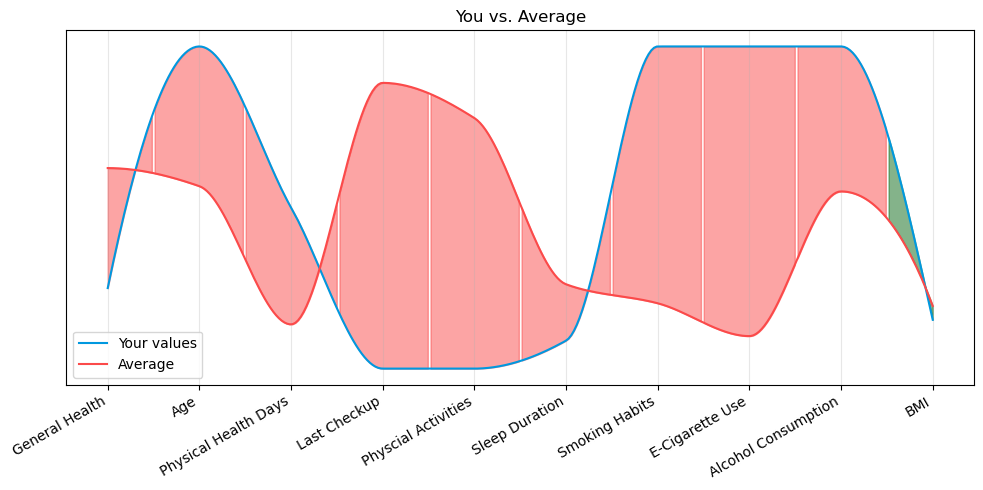

In [45]:
from scipy.interpolate import PchipInterpolator

x_smooth = np.linspace(x.min(), x.max(), 300)                   # Smooth x-axis & curves to prevent jagged look
spl_you = PchipInterpolator(x, rp_scaled)                       
spl_avg = PchipInterpolator(x, avg_scaled)                     
rp_smooth = spl_you(x_smooth)
avg_smooth = spl_avg(x_smooth)

# Plot showcase and markings if better/worse
plt.style.use("default")
plt.figure(figsize=(10, 5))
plt.plot(x_smooth, rp_smooth, label="Your values", color="#0098df")
plt.plot(x_smooth, avg_smooth, label="Average", color="#fb4a4a")

# segment bounds for coloring positive/negative difference from average individually for each feature
bounds = np.concatenate(([x[0] - 0.5],
                (x[:-1] + x[1:]) / 2,
                [x[-1] + 0.5]))

for i in range(len(features)):
    seg = (x_smooth >= bounds[i]) & (x_smooth <= bounds[i+1])
    color = "#0a6917" if better_mask[i] else "#fb4a4a"
    plt.fill_between(x_smooth[seg], rp_smooth[seg], avg_smooth[seg],
                    alpha=0.5, color=color)


ax = plt.gca()
ax.set_yticks([])
ax.set_yticklabels([])     
plt.xticks(x, ['General Health', 'Age', 'Physical Health Days', 
               'Last Checkup', 'Physcial Activities', 'Sleep Duration', 
               'Smoking Habits', 'E-Cigarette Use', 'Alcohol Consumption', 
               'BMI'], 
               rotation=30, ha="right")
plt.title("You vs. Average")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# IMPORTANT: For security reasons, we cannot provide the private API key we initially used in this code cell.
# In order for the code to run, input a new API key/ run streamlit
#*************************************

# Language Model advice web - Help fixing your bad values
from openai import OpenAI
client = OpenAI(api_key="")

# Information to forward to GPT for understanding prediction, feature averages and person values 
risk_status = "High risk" if random_person_pred == 1 else "Low risk"
person_scaled_list = rp_scaled.tolist()
average_scaled_list = avg_scaled.tolist()
feature_list = features
better_list = higher_better.tolist()

# Text to explain number higher better logic for each specific column
direction_text = """
GeneralHealth: higher = better
AgeCategory: higher = worse
PhysicalHealthDays: higher = worse
LastCheckupTime: higher = better
PhysicalActivities: higher = better
SleepHours: higher = better
SmokerStatus: higher = worse
ECigaretteUsage: higher = worse
AlcoholDrinkers: higher = worse
BMI: higher = worse
"""

# Promt to forward to GPT
prompt = f"""
You are a simple, realistic health advisor, to append an Heart Disease Risk model.
You MUST base all judgments only on the numeric lists and rules below.
Do not use stereotypes or general knowledge beyond these values.

Model prediction: {risk_status}

Features in this order:
{feature_list}
Person's scaled values (same order as features):
{person_scaled_list}
Average scaled values (same order as features):
{average_scaled_list}

How to interpret higher values (each feature):
{direction_text}

TASK: Compare the person's medical values for assessings heart disease risk against the average values and give clear, medical advice for improvement.
The response should be:

1) Adressed to the person the values are of
2) about 4-6 Sentences in english - structure them well dont make them too long (if needed exceed 4-6 setnences by spliting a long one in 2)
3) If risk is low start with good things, if high start with bad - keep in mind the higher - lower logic 
4) If a value is at the best level after the low/high logic dont suggest improvenements but tips to keep this as a strength
5) If there are no clearly good areas, do not invent any. It is fine to say if most areas need attention. 
6) Give clear, practical lifestyle suggestions where meaningful - for example, (not necessarly use this) try quitting app, help groups, 
   set limits, exercise with friends, dry janurary etc., and concrete suggestions how to do so
7) Keep the tone realistic and neutral, not overly optimistic.
8) Do NOT use numbers in the response. Do NOT directly talk about scaling or data.
"""

# Send request
response = client.chat.completions.create(
    model="gpt-5.1",
    messages=[{"role": "user", "content": prompt}])
advice_text = response.choices[0].message.content

# Output
symbol = "🟢" if risk_status == "Low risk" else "⭕"
print(f"Heart Disease Model: {risk_status} {symbol}")
print()
print(advice_text)